In [1]:
# !/usr/bin/env python
# coding: utf-8

import argparse
import os
import time
import ot

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter
from tqdm import tqdm
from scipy import stats
import proplot as pplt

import warnings
warnings.filterwarnings("ignore")

# TODO: DELETE
import sys
sys.argv = ['']

parser = argparse.ArgumentParser()
parser.add_argument('-d', '--dataset_name', default='breast-cancer', help='set the dataset')
parser.add_argument('-n', '--num_clients', default=10, type=int, help='set the number of clients')
parser.add_argument('-m', '--mc_iter', default=200, type=int, help='set the number of Monte Carlo iterations')
parser.add_argument('-b', '--batch_size', default=12, type=int, help='set the mini-batch size')
parser.add_argument('--prop_ula', default=1, type=float, help='set the proportion of data used for each SGLD update')
parser.add_argument('-t', '--temperature', default=1, type=float, help='set the l2 regularization parameter')
parser.add_argument('-l', '--l2', default=1., type=float, help='set the l2 regularization parameter')
parser.add_argument('-s', '--seed', default=-1, type=int, help='set the seed')
args = parser.parse_args()

# TODO: DELETE
args.dataset_name='titanic'
args.num_clients=10 
args.mc_iter=250000
args.prop_ula=1
args.batch_size=1
args.lr=1e-2

# Define the title to save the results
title = args.dataset_name
for key, value in {'numclients_': args.num_clients, 'm_': args.mc_iter, 'batch_': args.batch_size}.items():
    title += '-' + key + str(value)
    
# Save the path to store the data
path_workdir = '/gpfs/workdir/plassierv/22-fed_avg-neurips/toy_gaussian/' if os.path.isdir(
    '/gpfs/workdir/plassierv/') else './'
path_figures = path_workdir + 'figures/'
path_variables = path_workdir + 'variables/'

# TODO: delete
path_variables = path_workdir + "sh_files/huawei/variables/"


def load_samples(path_variables, args_key, name_mthd, num_samples = 1000, burnin_percentage=.1, verbose = False):
    
    name_mthd = name_mthd + '-'
    samples_mthd = None
    
    min_length = num_samples
    
    iterator = os.listdir(path_variables)
    iterator = tqdm(iterator) if verbose else iterator
    
    for f in iterator:
        if not f.endswith(".npy"):
            continue
        if False not in list(map(lambda s: s in f, args_key)) and f[:len(name_mthd)] == name_mthd:
            samples = np.load(os.path.join(path_variables, f))
            samples = samples[int(burnin_percentage * len(samples)):]
            min_length = min(min_length, len(samples))
            idx = np.unique(np.linspace(0, len(samples) - 1, min_length, dtype=int))
            samples = np.take(samples, idx, axis=0)[np.newaxis]
        else:
            continue
        if samples_mthd is None:
            samples_mthd = samples
        else:
            samples_mthd = np.concatenate((samples_mthd[:,-min_length:], samples))
    return samples_mthd

In [3]:
# Define the used methods
method_keys = ['salad', 'vr_salad', 'salad_star', 'vr_salad_star']
legend_name = {'salad': 'SALaD', 'vr_salad': 'VR-SALaD', 'salad_star': r'SALaD$^\star$', 'vr_salad_star': r'VR-SALaD$^\star$', 'ula': 'LSD'}

# Define the necessary arguments
args_key = title.split('-')  # list(map(str, [args.dataset_name, args.mc_iter, args.num_clients, args.batch_size, args.seed]))

# Start the timer
startTime = time.time()

# Define the Wasserstein distance dictionary
wasserstein_dict = {}

# Subsample parameters
num_samples = 650

# Number of points
num_pts = 100

# Load the ULA samples
samples_ula = load_samples(path_variables, args_key, 'ula', num_samples).transpose(1, 0, 2)
dim = samples_ula.shape[-1]
samples_ula = samples_ula.reshape(-1, dim)
q = ot.unif(len(samples_ula))

# Print the samples shape
# print(f'Reference sample = {samples_ula.shape}')

# To approximate th Wasserstein via Sinkhorn algorithm
sinkhorn = False

# To follow the execution
verbose = True

# To perform Wasserstein using the PCA tranform
pca = False
if pca:
    pca_transform = PCA(n_components=2)
    samples_ula = pca_transform.fit_transform(samples_ula)

# Define the indices used to compute the Wasserstein
idx_samples = np.unique((2 ** (np.log(num_samples) / np.log(2) * np.linspace(0, 1, num_pts)) - 1).astype(int))

for name_mthd in method_keys:
    
    samples_mthd = load_samples(path_variables, args_key, name_mthd, num_samples)
    
    # Define the iterator
    iterator = tqdm(idx_samples) if verbose else idx_samples
    
    wasserstein_dict[name_mthd] = np.zeros(len(iterator))
    
    for it, k in enumerate(iterator):

        samples = samples_mthd[:, :k + 1].reshape(-1, dim)
        if pca:
            samples = pca_transform.transform(samples)
        
        # Needed to compute the Wasserstein distance
        p = ot.unif(len(samples))
        M = ot.dist(samples, samples_ula)       

        if sinkhorn and k > 500:
            # Compute the transport plane using Sinkhorn
            Tplane = ot.bregman.sinkhorn(p, q, M, reg=1)
            
            # Compute the Wasserstein loss
            wasserstein = np.sum(Tplane * M)
        else:
            wasserstein = ot.emd2(p, q, M)

        # Save the distance
        wasserstein_dict[name_mthd][it] = np.copy(wasserstein)
    
# End the timer
executionTime = time.time() - startTime
print("Execution time =", executionTime)

100%|███████████████████████████████████████████████████████████████████████████████| 72/72 [2:27:56<00:00, 123.28s/it]

Execution time = 36260.9415678978


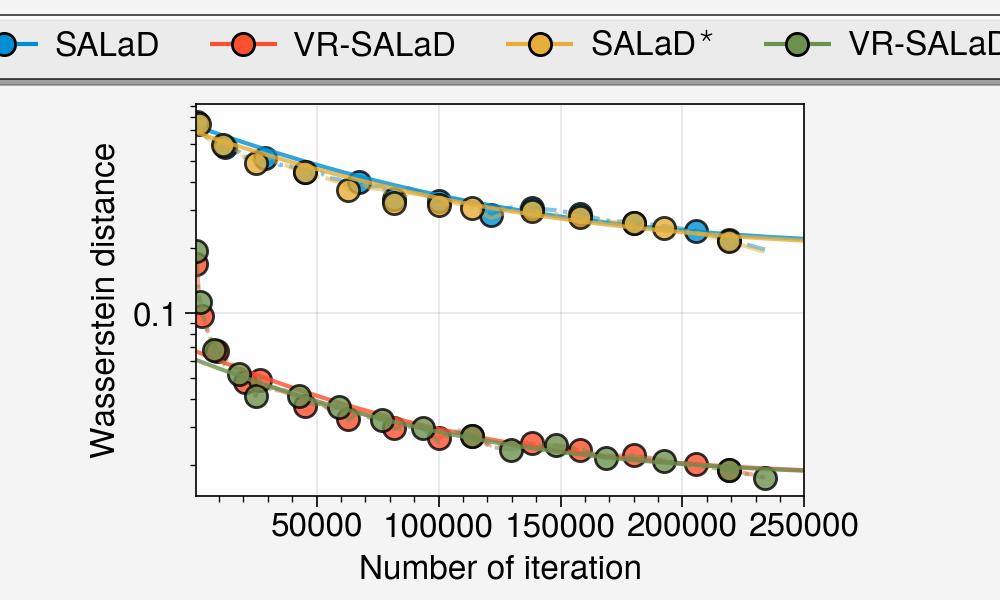

In [57]:
# Set the color
pplt.rc.cycle = '538'

fig, ax = pplt.subplots(figsize=(5, 3))

for key, item in wasserstein_dict.items(): # TODO: pb car sous-échantillonnage
    xx = (args.mc_iter / num_samples) * (idx_samples + 1)
    idx = np.where(np.abs(np.diff(item)) < .05)[0]
    idx = np.unique(np.concatenate((idx, idx + 1))) 
    item, x = np.take(item, idx, axis=0), np.take(xx, idx, axis=0)
    ind = int(.8 * len(item))
    
    c = item[-1]
    res = stats.linregress(x[ind:-1], np.log(item[ind:] - c)[:-1])
    a, b = np.exp(res.intercept),  np.exp(res.slope)
    
    ax.plot(x, item, ls='-.', alpha=.5)
    ax.plot(x, item, ls='', alpha=.8, color=ax.get_lines()[-1].get_c(), marker='o', markevery=0.07, ms=8, markeredgecolor='k', markeredgewidth=1)
    ax.plot([], [], ls='-', color=ax.get_lines()[-1].get_c(), marker='o', ms=8, markeredgecolor='k', markeredgewidth=1, label=legend_name[key])
    ax.plot(xx, c + a * b ** xx, ls='-', alpha=.8, color=ax.get_lines()[-1].get_c())
    
    # res = stats.linregress(x[ind:], item[ind:])
    # ax.plot(xx, res.intercept + res.slope * xx, color=ax.get_lines()[-1].get_c())
    # print(key, res.intercept)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.format(grid=True, xlabel=r"Number of iteration", ylabel=r"Wasserstein distance", fontsize=12)
fig.legend(loc='top',
           fontsize=15,
           prop={'size': 12},
           order='C',
           ncol=4,
           # title="Algorithm",
           title_fontsize=12,
           frameon=True,
           shadow=True,
           facecolor='gray2',
           edgecolor='k',
           labelspacing=1,
           handlelength=2)

fig.savefig(os.path.join(path_figures, title + '-wasserstein.pdf'), bbox_inches='tight')

# Save the MSE dictionary
path_save = os.path.join(path_variables, title + '-wasserstein_dict')
np.save(path_save, wasserstein_dict)

In [54]:
path_save

'./sh_files/huawei/variables/titanic-numclients_10-m_250000-batch_1-wasserstein_dict'

In [2]:
%%time
####################################################################
################### TO COMPUTE WITH MORE SAMPLES ###################
####################################################################

# Define the used methods
method_keys = {'salad', 'vr_salad', 'salad_star', 'vr_salad_star'}

# Define the necessary arguments
args_key = title.split("-")

# Start the timer
startTime = time.time()

# Define the Wasserstein distance dictionary
wasserstein_dict = {}

# Subsample parameters
num_samples = 650

# Load the ULA samples
samples_ula = load_samples(path_variables, args_key, 'ula', num_samples).transpose(1, 0, 2)
dim = samples_ula.shape[-1]
samples_ula = samples_ula.reshape(-1, dim)
q = ot.unif(len(samples_ula))

# To approximate th Wasserstein via Sinkhorn algorithm
sinkhorn = False

for name_mthd in tqdm(method_keys):
    
    samples_mthd = load_samples(path_variables, args_key, name_mthd, num_samples)
    samples = samples_mthd.reshape(-1, dim)
    
    # print(f'{name_mthd.upper()} = {samples.mean(axis=0)}')

    # Needed to compute the Wasserstein distance
    p = ot.unif(len(samples))
    M = ot.dist(samples, samples_ula)       

    if sinkhorn:
        # Compute the transport plane using Sinkhorn
        Tplane = ot.bregman.sinkhorn(p, q, M, reg=1)

        # Compute the Wasserstein loss
        wasserstein = np.sum(Tplane * M)
    else:
        wasserstein = ot.emd2(p, q, M)

    # Save the distance
    wasserstein_dict[name_mthd] = wasserstein
    
# Plot the Wasserstein loss
for key, item in wasserstein_dict.items():
    print(f'{key.upper()} = {np.round(item, 3)}')
    
# To compare with a Gaussian approximation
samples = samples_ula.mean(axis=0) + np.std(samples_ula, axis=0) * np.random.randn(*samples.shape)
M = ot.dist(samples, samples_ula) 
wasserstein = ot.emd2(p, q, M)
print('Gaussian ='.upper(), np.round(wasserstein, 3))

# End the timer
executionTime = time.time() - startTime
print("Execution time =", executionTime)

####################################################################

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [56:16<00:00, 844.18s/it]


VR_SALAD = 0.303
SALAD = 0.768
VR_SALAD_STAR = 0.385
SALAD_STAR = 0.713
GAUSSIAN = 0.012
Execution time = 4217.8849556446075
Wall time: 1h 10min 17s


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.83it/s]


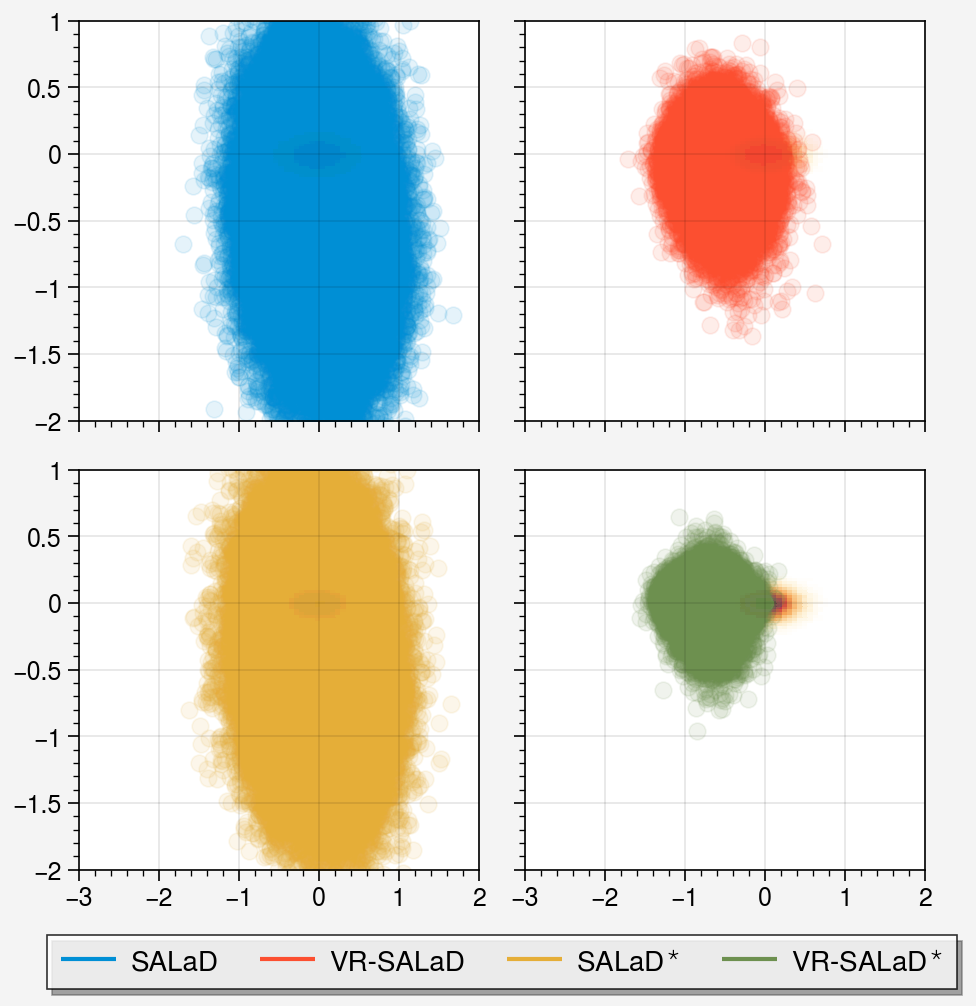

In [176]:
from sklearn.decomposition import PCA

# Subsample parameters
num_samples = 10000

# Load the ULA samples
samples_ula = load_samples(path_variables, args_key, 'ula', num_samples).transpose(1, 0, 2)
dim = samples_ula.shape[-1]
samples_ula = samples_ula.reshape(-1, dim)

# Define the PCA
pca = PCA(n_components=2).fit(samples_ula)
# pca = PCA(n_components=2).fit(load_samples(path_variables, args_key, 'vr_salad_star', num_samples).reshape(-1, dim))

# Display the results
fig, axs = pplt.subplots(nrows=2, ncols=2, refwidth=2)

samples_ula_pca = pca.transform(samples_ula)

axs.hist2d(samples_ula_pca[:, 0], samples_ula_pca[:, 1], bins=30, alpha=1 , density=True)

for it, name_mthd in enumerate(tqdm(method_keys)):
    
    samples_mthd = load_samples(path_variables, args_key, name_mthd, num_samples).reshape(-1, dim)
    
    samples = pca.transform(samples_mthd)

    axs[it].scatter(samples[:, 0], samples[:, 1], alpha=0.1, color=('538', it))
    axs[it].plot([], [], color=('538', it), label=legend_name[name_mthd])
    # axs[it].format(title=legend_name[name_mthd])
    
axs.format(grid=True, xlim=[-3, 2], ylim=[-2, 1])

fig.legend(loc='bottom',
           fontsize=12,
           prop={'size': 10},
           order='C',
           ncol=4,
           title_fontsize=12,
           frameon=True,
           shadow=True,
           facecolor='gray2',
           edgecolor='k',
           labelspacing=1,
           handlelength=2)